In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Data Exploration

## Warnings (could be commented out)

In [2]:
import warnings

# --- Suppress XGBoost GPU warnings ---
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
warnings.filterwarnings("ignore", message=".*Falling back to prediction using DMatrix.*")

# --- Suppress pandas FutureWarnings ---
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Suppress sklearn ConvergenceWarnings ---
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
from sklearn.exceptions import ConvergenceWarning

In [4]:
path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(path)

path = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
test_df =  pd.read_csv(path)

print("Full train dataset shape is {}".format(dataset_df.shape))
print("Full test dataset shape is {}".format(test_df.shape))

Full train dataset shape is (1460, 81)
Full test dataset shape is (1459, 80)


In [5]:
dataset_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
test_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [7]:
dataset_df = dataset_df.drop('Id', axis=1)

dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [8]:
test_df = test_df.drop('Id', axis=1)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

In [9]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Data distribution  

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 900x800 with 0 Axes>

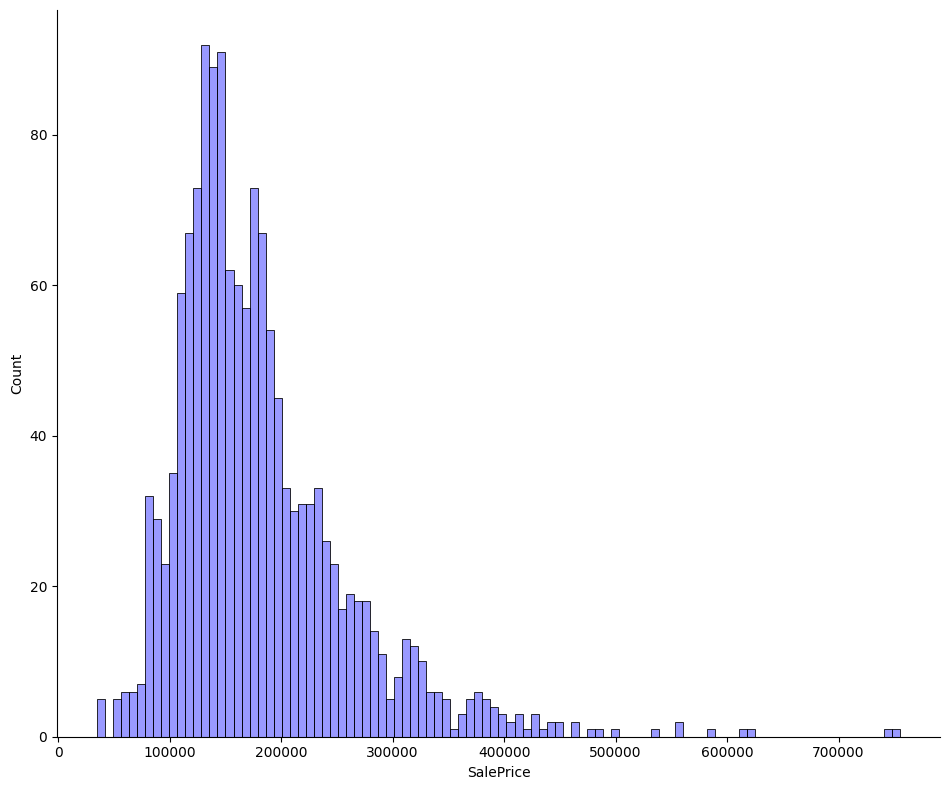

In [10]:
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.displot(dataset_df['SalePrice'], color='b', bins=100, alpha=0.4, height=8, aspect=1.2)

In [11]:
list(set(dataset_df.dtypes.tolist()))

[dtype('O'), dtype('float64'), dtype('int64')]

In [12]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


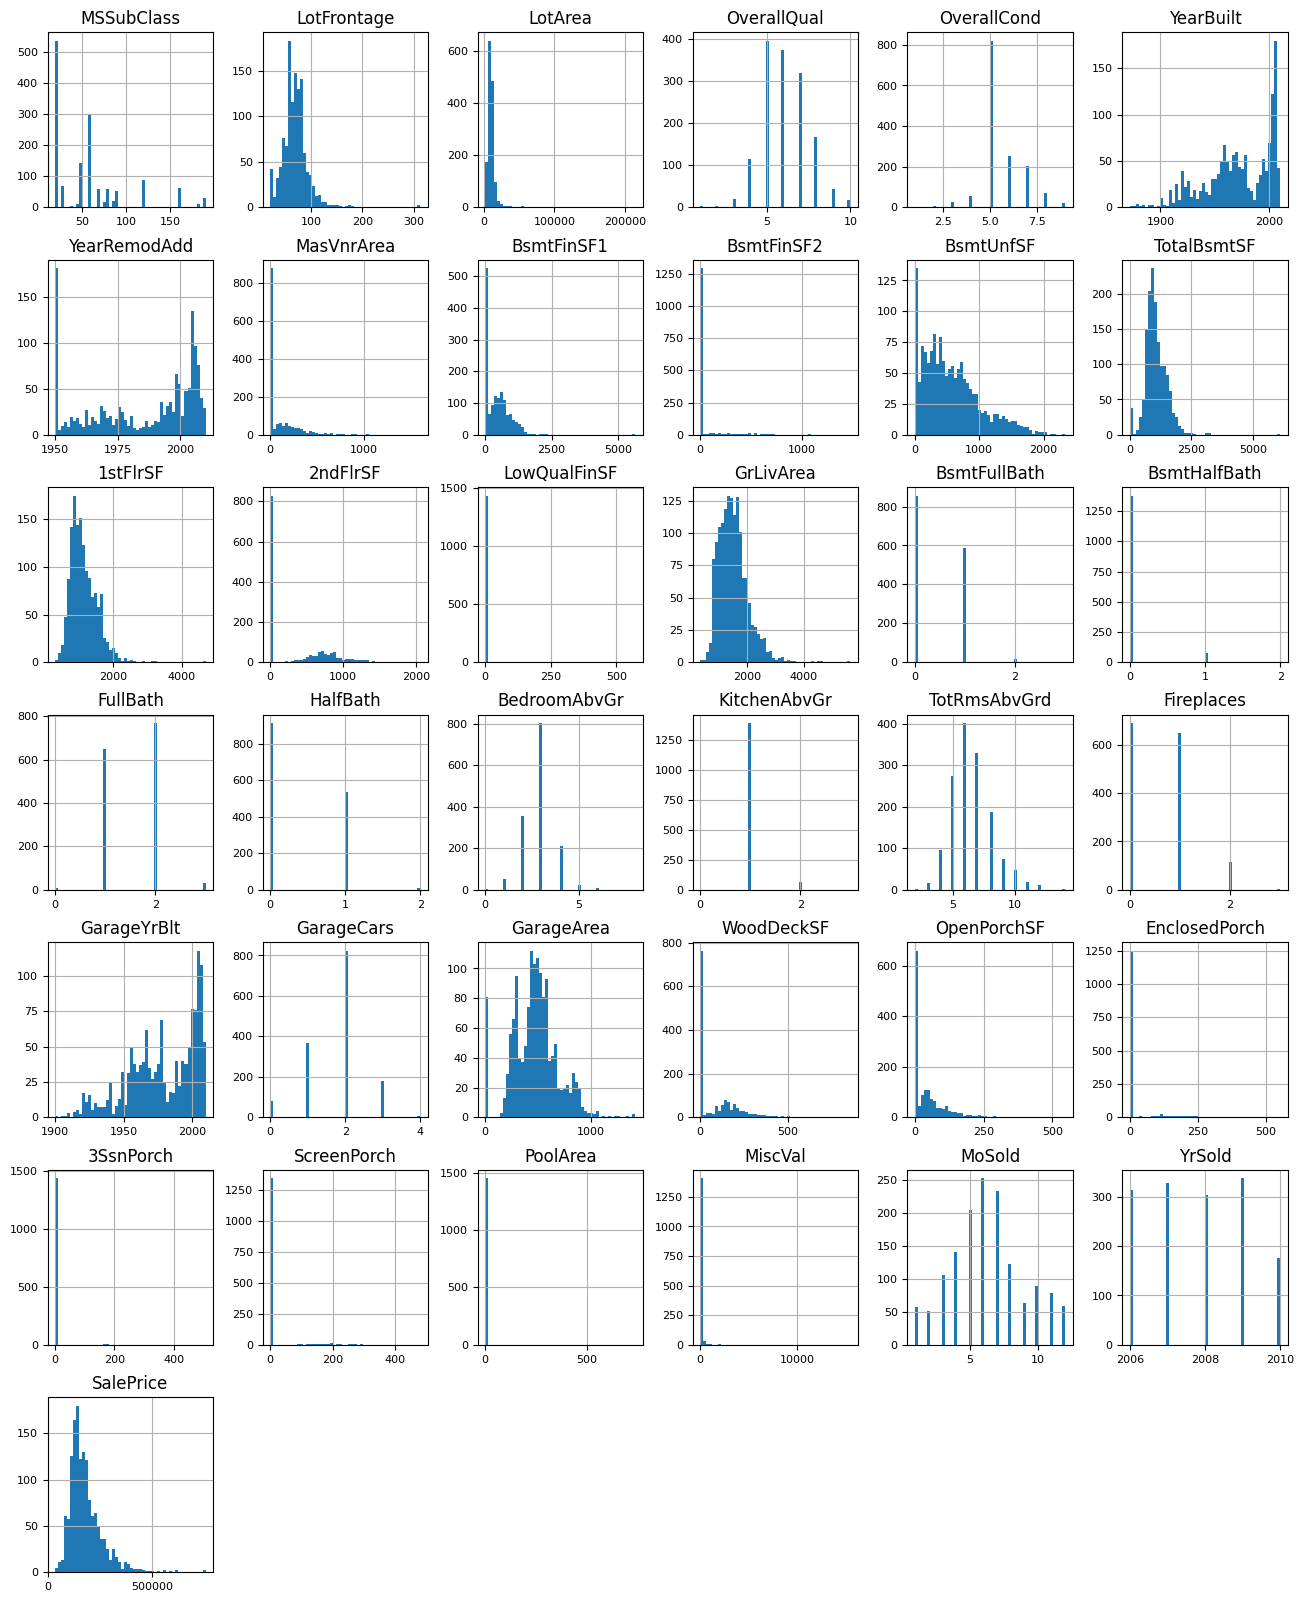

In [13]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

# Data Cleaning and Feature Engineering

In [14]:
def clean_nans(df):

    none_cols = ['Alley','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                 'BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual',
                 'GarageCond','PoolQC','Fence','MiscFeature','ExterQual','ExterCond',
                 'HeatingQC','KitchenQual']

    for col in none_cols:
        df[col] = df[col].fillna('None')

    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage']\
                          .transform(lambda x: x.fillna(x.median()))

    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])

    if df['Electrical'].isna().sum() > 0:
        df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

    df['MSSubClass'] = df['MSSubClass'].astype(str)

    return df

In [15]:
def preprocess(df):

    none_cols = ['Alley','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                 'BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual',
                 'GarageCond','PoolQC','Fence','MiscFeature','ExterQual','ExterCond',
                 'HeatingQC','KitchenQual']

    for col in none_cols:
        df[col] = df[col].fillna('None')

    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage']\
                          .transform(lambda x: x.fillna(x.median()))

    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])

    if df['Electrical'].isna().sum() > 0:
        df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

    df['MSSubClass'] = df['MSSubClass'].astype(str)

    # ENGINEERING
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
    df['IsRemodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)

    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBathrooms'] = (df['FullBath'] + 0.5*df['HalfBath'] +
                            df['BsmtFullBath'] + 0.5*df['BsmtHalfBath'])
    df['TotalPorchSF'] = (df['OpenPorchSF'] + df['EnclosedPorch'] +
                          df['3SsnPorch'] + df['ScreenPorch'])

    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    df['HasBasement'] = (df['TotalBsmtSF'] > 0).astype(int)
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    df['Has2ndFloor'] = (df['2ndFlrSF'] > 0).astype(int)
    df['HasWoodDeck'] = (df['WoodDeckSF'] > 0).astype(int)

    df['OverallScore'] = df['OverallQual'] * df['OverallCond']

    # ORDINAL MAPS
    quality_map = {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
    basement_fin_map = {'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}
    basement_exp_map = {'None':0,'No':1,'Mn':2,'Av':3,'Gd':4}
    garage_finish_map = {'None':0,'Unf':1,'RFn':2,'Fin':3}
    fence_map = {'None':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4}

    # QUALITY COLUMNS
    quality_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC',
                    'KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC']

    for col in quality_cols:
        df[col] = df[col].astype(str).map(quality_map).fillna(0).astype(int)

    df['BsmtExposure'] = df['BsmtExposure'].astype(str).map(basement_exp_map).fillna(0).astype(int)
    df['BsmtFinType1'] = df['BsmtFinType1'].astype(str).map(basement_fin_map).fillna(0).astype(int)
    df['BsmtFinType2'] = df['BsmtFinType2'].astype(str).map(basement_fin_map).fillna(0).astype(int)
    df['GarageFinish'] = df['GarageFinish'].astype(str).map(garage_finish_map).fillna(0).astype(int)
    df['Fence'] = df['Fence'].astype(str).map(fence_map).fillna(0).astype(int)

    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(0)

    # Fill remaining categorical NaNs
    cat_cols = df.select_dtypes(include=['object']).columns
    df[cat_cols] = df[cat_cols].fillna('None')

    return df


In [16]:


df = dataset_df.copy()

In [17]:
df_eng = preprocess(df)
df_eng = pd.get_dummies(df_eng, drop_first=True)

test_eng = preprocess(test_df)
test_eng = pd.get_dummies(test_eng, drop_first=True)
test_eng = test_eng.reindex(columns=df_eng.columns, fill_value=0)

df_orig = clean_nans(dataset_df.copy())
df_orig = pd.get_dummies(df_orig, drop_first=True)

print(df_eng.shape)
print(test_eng.shape)
print(df_orig.shape)   

(1460, 239)
(1459, 239)
(1460, 273)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [18]:
test_orig = clean_nans(test_df.copy())
test_orig = pd.get_dummies(test_orig, drop_first=True)
test_orig = test_orig.reindex(columns=df_orig.columns, fill_value=0)
print(test_orig .shape)

(1459, 273)


# Linear Models

In [19]:
class ModelBucket:
    
    def __init__(self):
        self.models = {}  # Store trained models
        self.scalers = {}  # Store scalers
        self.results = []  # Store all metrics
        
    def train_model(self, X, y, model_type, params=None, 
                   data_version='original', test_size=0.2, 
                   random_state=42, scale_features=True, 
                   max_iter=10000):
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Scale features if requested (though this might not be needed tbh)
        scaler = None
        if scale_features:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test
        
        # Initialize model
        if params is None:
            params = {}
            
        model_map = {
            'linear': LinearRegression,
            'ridge': Ridge,
            'lasso': Lasso,
            'elastic_net': ElasticNet
        }
        
        model = model_map[model_type](**params)
        
        # Train model
        start_time = datetime.now()
        model.fit(X_train_scaled, y_train)
        train_time = (datetime.now() - start_time).total_seconds()
        
        # Make predictions
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        train_metrics = {
            'mse': mean_squared_error(y_train, y_train_pred),
            'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'mae': mean_absolute_error(y_train, y_train_pred),
            'r2': r2_score(y_train, y_train_pred)
        }
        
        test_metrics = {
            'mse': mean_squared_error(y_test, y_test_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
            'mae': mean_absolute_error(y_test, y_test_pred),
            'r2': r2_score(y_test, y_test_pred)
        }
        
        # Cross-validation score
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, 
                                    scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores.mean())
        
        # Create model ID
        param_str = '_'.join([f"{k}{v}" for k, v in params.items()]) if params else 'default'
        model_id = f"{model_type}_{data_version}_{param_str}"
        
        # Store model and scaler
        self.models[model_id] = model
        self.scalers[model_id] = scaler
        
        # Store results
        result = {
            'model_id': model_id,
            'model_type': model_type,
            'data_version': data_version,
            'params': params,
            'train_r2': train_metrics['r2'],
            'train_rmse': train_metrics['rmse'],
            'train_mae': train_metrics['mae'],
            'test_r2': test_metrics['r2'],
            'test_rmse': test_metrics['rmse'],
            'test_mae': test_metrics['mae'],
            'cv_rmse': cv_rmse,
            'overfit': train_metrics['r2'] - test_metrics['r2'],
            'train_time': train_time,
            'n_features': X_train.shape[1],
            'n_samples': X_train.shape[0]
        }
        
        self.results.append(result)
        
        print(f"✓ {model_id}: Test R²={test_metrics['r2']:.4f}, RMSE={test_metrics['rmse']:.4f}")
        
        return result

    def train_all(self, df_original, df_engineered, target_col, 
                  test_size=0.2, random_state=42, scale_features=True):
        

        print("TRAINING LINEAR MODEL BUCKET")
        
        # Prepare datasets
        X_orig = df_original.drop(columns=[target_col])
        y_orig = df_original[target_col]
        
        X_eng = df_engineered.drop(columns=[target_col])
        y_eng = df_engineered[target_col]
        
        # Define parameter grids
        ridge_alphas = [0.1, 1.0, 10.0, 100.0]
        lasso_alphas = [0.01, 0.1, 1.0, 10.0]
        elastic_configs = [
            {'alpha': 0.1, 'l1_ratio': 0.3},
            {'alpha': 0.1, 'l1_ratio': 0.5},
            {'alpha': 1.0, 'l1_ratio': 0.3},
            {'alpha': 1.0, 'l1_ratio': 0.7}
        ]
              
        # Train Linear Regression
        print("\n Linear Regression (scaled only and not regularized)")
        self.train_model(X_orig, y_orig, "linear",
                 data_version="original",
                 test_size=test_size,
                 random_state=random_state,
                 scale_features=True)

        self.train_model(X_eng, y_eng, "linear",
                 data_version="engineered",
                 test_size=test_size,
                 random_state=random_state,
                 scale_features=True)
        
        # Train Ridge Regression
        print("\nRidge Regression")
        for alpha in ridge_alphas:
            self.train_model(X_orig, y_orig, 'ridge', params={'alpha': alpha},
                           data_version='original', test_size=test_size,
                           random_state=random_state, scale_features=scale_features)
            self.train_model(X_eng, y_eng, 'ridge', params={'alpha': alpha},
                           data_version='engineered', test_size=test_size,
                           random_state=random_state, scale_features=scale_features)
        
        # Train Lasso Regression
        print("\nLasso Regression")
        for alpha in lasso_alphas:
            self.train_model(X_orig, y_orig, 'lasso', params={'alpha': alpha},
                           data_version='original', test_size=test_size,
                           random_state=random_state, scale_features=scale_features)
            self.train_model(X_eng, y_eng, 'lasso', params={'alpha': alpha},
                           data_version='engineered', test_size=test_size,
                           random_state=random_state, scale_features=scale_features)
        
        # Train Elastic Net
        print("\nElastic Net")
        for params in elastic_configs:
            self.train_model(X_orig, y_orig, 'elastic_net', params=params,
                           data_version='original', test_size=test_size,
                           random_state=random_state, scale_features=scale_features)
            self.train_model(X_eng, y_eng, 'elastic_net', params=params,
                           data_version='engineered', test_size=test_size,
                           random_state=random_state, scale_features=scale_features)
        
        print(f"COMPLETE: {len(self.results)} models trained")


    def get_results_df(self):
        return pd.DataFrame(self.results)
    
    def compare(self, metric='test_r2', top_n=10):
        
        df = self.get_results_df()
        
        # Sort by metric
        ascending = 'rmse' in metric.lower() or 'mae' in metric.lower() or 'mse' in metric.lower()
        df_sorted = df.sort_values(metric, ascending=ascending)
        
        print(f"TOP {top_n} MODELS BY {metric.upper()}")
        
        display_cols = ['model_id', 'test_r2', 'test_rmse', 'cv_rmse', 'overfit', 'params']
        print(df_sorted[display_cols].head(top_n).to_string(index=False))
        
        # Summary statistics
        print("SUMMARY BY MODEL TYPE")
        summary = df.groupby('model_type').agg({
            'test_r2': ['mean', 'max'],
            'test_rmse': ['mean', 'min'],
            'cv_rmse': 'mean'
        }).round(4)
        print(summary)
        
        print("SUMMARY BY DATA VERSION")
        summary = df.groupby('data_version').agg({
            'test_r2': ['mean', 'max'],
            'test_rmse': ['mean', 'min']
        }).round(4)
        print(summary)
        
        return df_sorted
    
    def get_model(self, model_id):
        if model_id not in self.models:
            raise ValueError(f"Model {model_id} not found")
        return self.models[model_id], self.scalers[model_id]
    
    def predict(self, model_id, X):
        model, scaler = self.get_model(model_id)
        
        if scaler is not None:
            X_scaled = scaler.transform(X)
        else:
            X_scaled = X
            
        return model.predict(X_scaled)
    
    def get_best_model(self, metric='test_r2'):
        df = self.get_results_df()
        ascending = 'rmse' in metric.lower() or 'mae' in metric.lower()
        df_sorted = df.sort_values(metric, ascending=ascending)
        best_id = df_sorted.iloc[0]['model_id']
        return self.get_model(best_id), best_id

## Creates Bucket and Training 

In [20]:
# 1. Create bucket
bucket = ModelBucket()

# 2. Train all models
bucket.train_all(df_orig, df_eng, target_col='SalePrice')


TRAINING LINEAR MODEL BUCKET

 Linear Regression (scaled only and not regularized)
✓ linear_original_default: Test R²=-313716869999052587008.0000, RMSE=1551228780544781.5000
✓ linear_engineered_default: Test R²=-2148573267534870272.0000, RMSE=128375456540704.8125

Ridge Regression
✓ ridge_original_alpha0.1: Test R²=0.7203, RMSE=46317.0147
✓ ridge_engineered_alpha0.1: Test R²=0.6527, RMSE=51609.9372
✓ ridge_original_alpha1.0: Test R²=0.8266, RMSE=36465.2168
✓ ridge_engineered_alpha1.0: Test R²=0.6910, RMSE=48681.2843
✓ ridge_original_alpha10.0: Test R²=0.8452, RMSE=34462.0983
✓ ridge_engineered_alpha10.0: Test R²=0.8123, RMSE=37939.3127
✓ ridge_original_alpha100.0: Test R²=0.8595, RMSE=32828.9265
✓ ridge_engineered_alpha100.0: Test R²=0.8680, RMSE=31818.6261

Lasso Regression
✓ lasso_original_alpha0.01: Test R²=0.8265, RMSE=36479.6414
✓ lasso_engineered_alpha0.01: Test R²=0.6488, RMSE=51898.5309
✓ lasso_original_alpha0.1: Test R²=0.8266, RMSE=36473.9649
✓ lasso_engineered_alpha0.1: Test

In [21]:
# 3. Compare models
results = bucket.compare(metric='test_r2', top_n=10)

# 4. Get best model
best_model, best_id = bucket.get_best_model(metric='test_r2')
print(f"Best model: {best_id}")

TOP 10 MODELS BY TEST_R2
                                   model_id  test_r2    test_rmse      cv_rmse  overfit                          params
                ridge_engineered_alpha100.0 0.868008 31818.626099 36686.820052 0.033050                {'alpha': 100.0}
elastic_net_engineered_alpha0.1_l1_ratio0.3 0.867536 31875.377107 37225.831708 0.035383 {'alpha': 0.1, 'l1_ratio': 0.3}
elastic_net_engineered_alpha0.1_l1_ratio0.5 0.865618 32105.298894 37676.262301 0.040350 {'alpha': 0.1, 'l1_ratio': 0.5}
elastic_net_engineered_alpha1.0_l1_ratio0.7 0.863559 32350.416404 35433.508815 0.022984 {'alpha': 1.0, 'l1_ratio': 0.7}
  elastic_net_original_alpha0.1_l1_ratio0.3 0.859628 32813.115847 37664.021510 0.060687 {'alpha': 0.1, 'l1_ratio': 0.3}
  elastic_net_original_alpha0.1_l1_ratio0.5 0.859518 32825.992327 38214.095763 0.063569 {'alpha': 0.1, 'l1_ratio': 0.5}
                  ridge_original_alpha100.0 0.859492 32828.926474 36962.268421 0.058961                {'alpha': 100.0}
  elastic_net_o

In [22]:
X_test = test_eng.drop(columns=['SalePrice'], errors='ignore')
preds = bucket.predict(best_id, X_test)

# 6. Access results as DataFrame
df_results = bucket.get_results_df()

## Linear Visualizations

In [23]:
print("Best model:", best_id)

print("\nAll model results:")
display(df_results.head(20))

Best model: ridge_engineered_alpha100.0

All model results:


,model_id,model_type,data_version,params,train_r2,train_rmse,train_mae,test_r2,test_rmse,test_mae,cv_rmse,overfit,train_time,n_features,n_samples
0,linear_original_default,linear,original,{},0.940580,18825.829603,12106.887183,-3.137169e+20,1.551229e+15,1.685534e+14,2.776015e+16,3.137169e+20,0.057362,272,1168
1,linear_engineered_default,linear,engineered,{},0.925607,21064.622449,14319.639110,-2.148573e+18,1.283755e+14,1.301886e+13,2.221478e+15,2.148573e+18,0.035716,238,1168
2,ridge_original_alpha0.1,ridge,original,{'alpha': 0.1},0.939915,18930.992142,12256.218186,7.203162e-01,4.631701e+04,2.040010e+04,3.993226e+04,2.195984e-01,0.021230,272,1168
3,ridge_engineered_alpha0.1,ridge,engineered,{'alpha': 0.1},0.925604,21065.073152,14317.594650,6.527415e-01,5.160994e+04,2.175626e+04,5.004974e+04,2.728627e-01,0.005144,238,1168
4,ridge_original_alpha1.0,ridge,original,{'alpha': 1.0},0.938319,19180.717457,12493.775392,8.266420e-01,3.646522e+04,1.969235e+04,4.081513e+04,1.116769e-01,0.021335,272,1168
5,ridge_engineered_alpha1.0,ridge,engineered,{'alpha': 1.0},0.925421,21090.936948,14315.932228,6.910343e-01,4.868128e+04,2.148882e+04,4.806413e+04,2.343871e-01,0.006582,238,1168
6,ridge_original_alpha10.0,ridge,original,{'alpha': 10.0},0.933638,19895.242194,12971.031866,8.451648e-01,3.446210e+04,1.969065e+04,4.046443e+04,8.847297e-02,0.021378,272,1168
7,ridge_engineered_alpha10.0,ridge,engineered,{'alpha': 10.0},0.920291,21804.370822,14611.264568,8.123429e-01,3.793931e+04,2.061753e+04,4.107003e+04,1.079478e-01,0.007671,238,1168
8,ridge_original_alpha100.0,ridge,original,{'alpha': 100.0},0.918453,22054.261446,14110.758236,8.594925e-01,3.282893e+04,2.010068e+04,3.696227e+04,5.896063e-02,0.020499,272,1168
9,ridge_engineered_alpha100.0,ridge,engineered,{'alpha': 100.0},0.901058,24292.883434,15569.887888,8.680076e-01,3.181863e+04,2.008636e+04,3.668682e+04,3.305049e-02,0.009314,238,1168


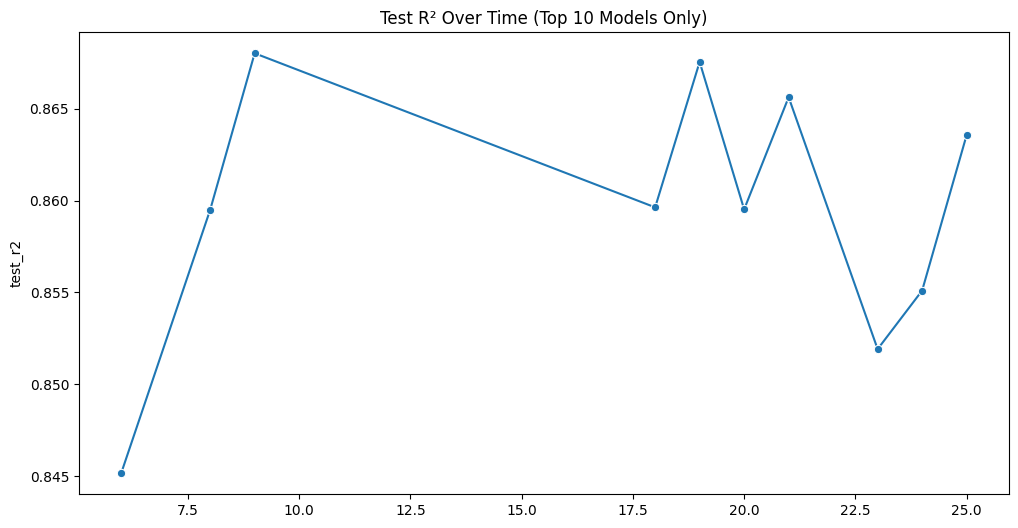

In [24]:
warnings.filterwarnings("ignore", category=FutureWarning)
df = bucket.get_results_df()
top10 = df.sort_values("test_r2", ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.lineplot(data=top10, x=top10.index, y='test_r2', marker='o')
plt.title("Test R² Over Time (Top 10 Models Only)")
plt.show()

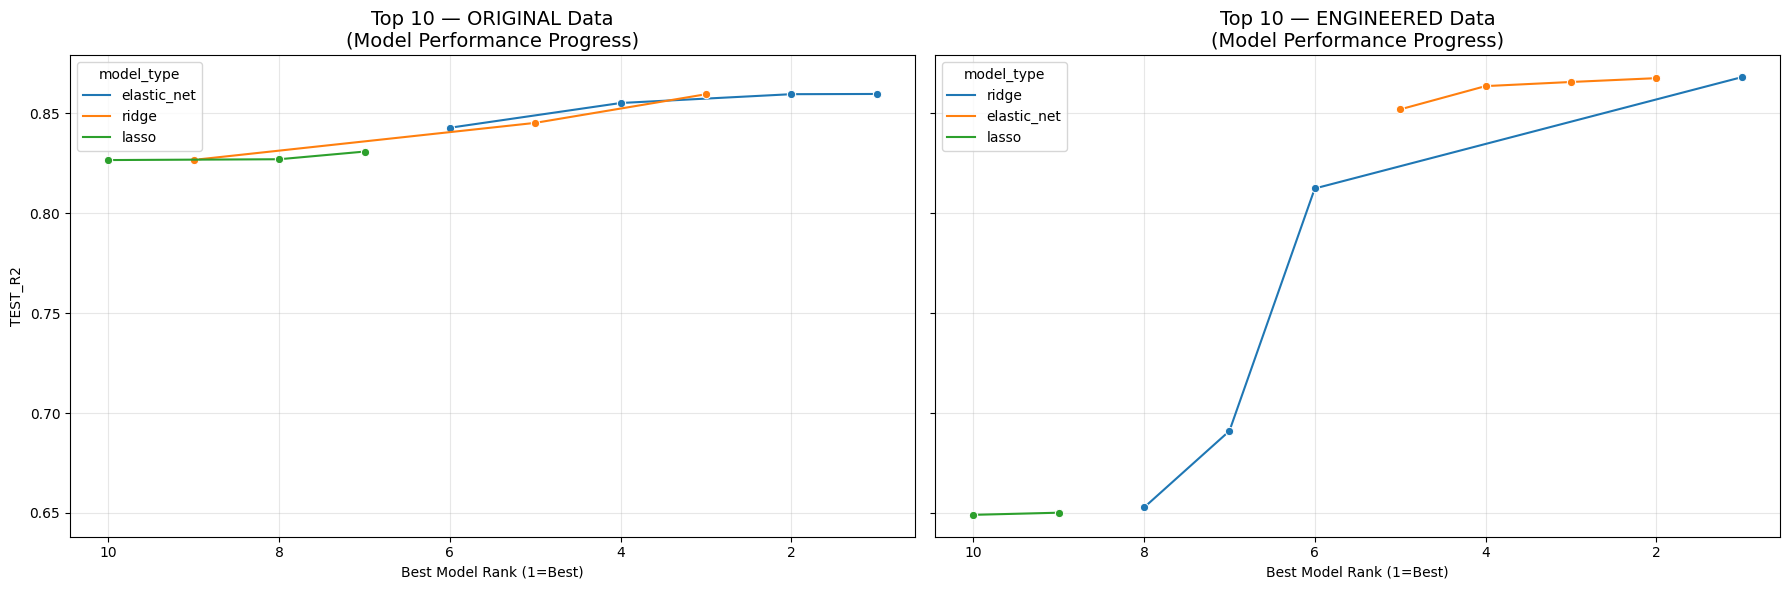

In [25]:
def plot_progress_split_top10(bucket, metric="test_r2"):
    df = bucket.get_results_df().copy()
    ascending = metric.lower() in ["rmse", "mae", "mse"]
    df = df[df[metric].between(-5, 2)]  # keeps normal R² range
    
    # Split by dataset version
    df_orig = df[df["data_version"] == "original"]
    df_eng  = df[df["data_version"] == "engineered"]

    # Sort and take top 10
    top10_orig = df_orig.sort_values(metric, ascending=ascending).head(10).copy()
    top10_eng  = df_eng.sort_values(metric, ascending=ascending).head(10).copy()
    top10_orig["step"] = range(1, len(top10_orig) + 1)
    top10_eng["step"]  = range(1, len(top10_eng) + 1)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    # ORIGINAL
    sns.lineplot(
        data=top10_orig, x="step", y=metric,
        hue="model_type", marker="o", ax=axes[0]
    )
    axes[0].set_title("Top 10 — ORIGINAL Data\n(Model Performance Progress)", fontsize=14)
    axes[0].set_xlabel("Best Model Rank (1=Best)")
    axes[0].set_ylabel(metric.upper())
    axes[0].invert_xaxis() 
    axes[0].grid(alpha=0.3)

    # ENGINEERED
    sns.lineplot(
        data=top10_eng, x="step", y=metric,
        hue="model_type", marker="o", ax=axes[1]
    )
    axes[1].set_title("Top 10 — ENGINEERED Data\n(Model Performance Progress)", fontsize=14)
    axes[1].set_xlabel("Best Model Rank (1=Best)")
    axes[1].set_ylabel("")
    axes[1].invert_xaxis()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
plot_progress_split_top10(bucket, metric="test_r2")


BEST MODEL PROGRESSION


,rank,model_id,model_type,data_version,params,test_r2
9,1,ridge_engineered_alpha100.0,ridge,engineered,{'alpha': 100.0},0.868008
19,2,elastic_net_engineered_alpha0.1_l1_ratio0.3,elastic_net,engineered,"{'alpha': 0.1, 'l1_ratio': 0.3}",0.867536
21,3,elastic_net_engineered_alpha0.1_l1_ratio0.5,elastic_net,engineered,"{'alpha': 0.1, 'l1_ratio': 0.5}",0.865618
25,4,elastic_net_engineered_alpha1.0_l1_ratio0.7,elastic_net,engineered,"{'alpha': 1.0, 'l1_ratio': 0.7}",0.863559
18,5,elastic_net_original_alpha0.1_l1_ratio0.3,elastic_net,original,"{'alpha': 0.1, 'l1_ratio': 0.3}",0.859628
20,6,elastic_net_original_alpha0.1_l1_ratio0.5,elastic_net,original,"{'alpha': 0.1, 'l1_ratio': 0.5}",0.859518
8,7,ridge_original_alpha100.0,ridge,original,{'alpha': 100.0},0.859492
24,8,elastic_net_original_alpha1.0_l1_ratio0.7,elastic_net,original,"{'alpha': 1.0, 'l1_ratio': 0.7}",0.855102
23,9,elastic_net_engineered_alpha1.0_l1_ratio0.3,elastic_net,engineered,"{'alpha': 1.0, 'l1_ratio': 0.3}",0.851918
6,10,ridge_original_alpha10.0,ridge,original,{'alpha': 10.0},0.845165


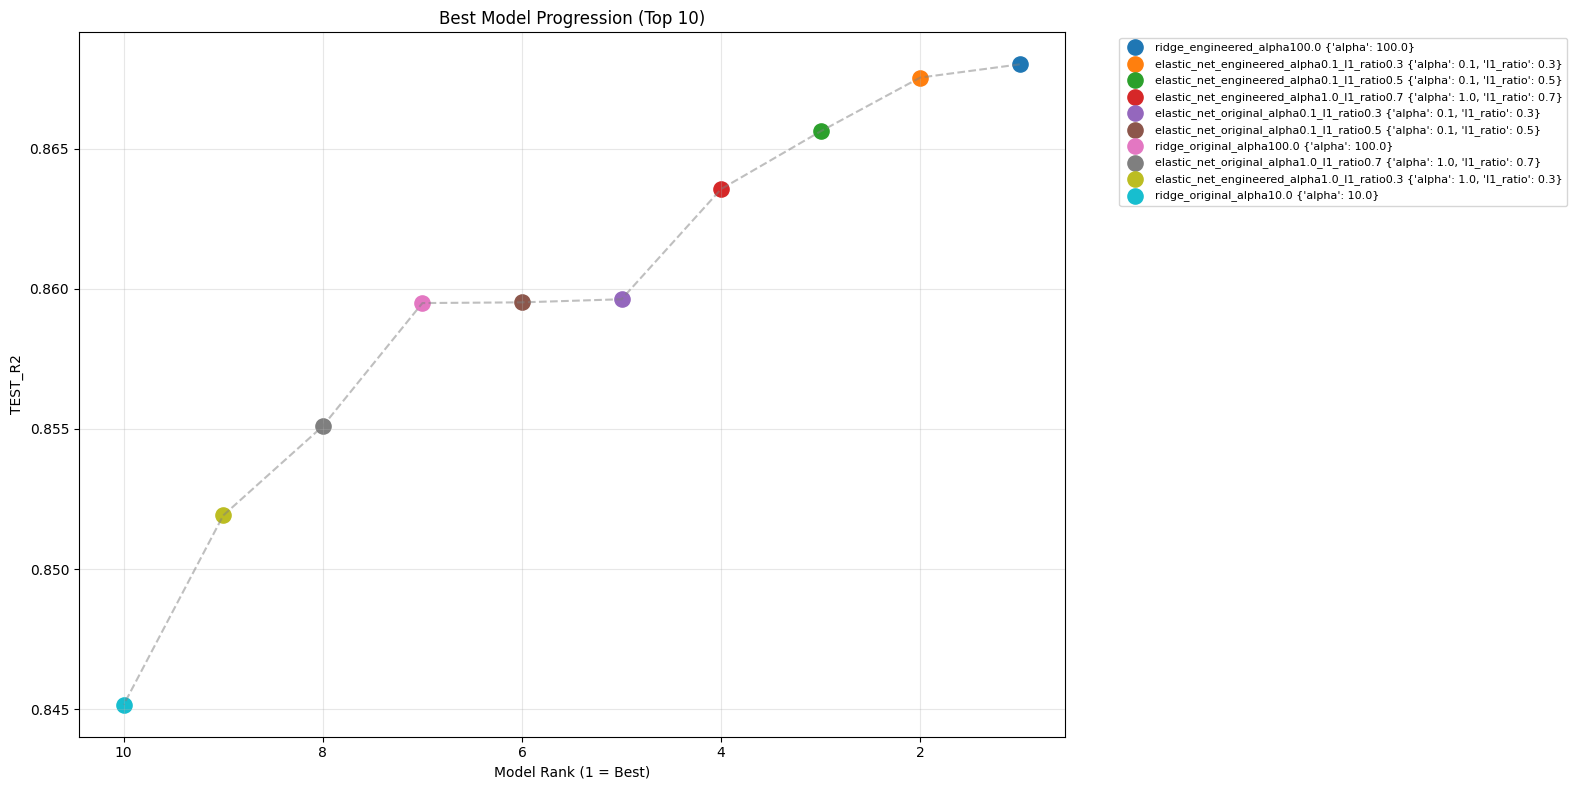

In [26]:
def plot_best_model_progression(bucket, metric="test_r2", top_n=10):
    df = bucket.get_results_df().copy()
    ascending = metric.lower() in ["rmse", "mae", "mse"]

    # Select top N
    best_df = df.sort_values(metric, ascending=ascending).head(top_n).copy()
    best_df["rank"] = range(1, len(best_df) + 1)

    # Print progression table
    print("BEST MODEL PROGRESSION")
    display(
        best_df[
            ["rank", "model_id", "model_type", "data_version", "params", metric]
        ].sort_values("rank")
    )

    plt.figure(figsize=(16, 8))

    for i, row in best_df.iterrows():
        plt.scatter(
            row["rank"], 
            row[metric], 
            s=120, 
            label=f"{row['model_id']} {row['params']}"
        )
    plt.plot(best_df["rank"], best_df[metric], linestyle="--", color="gray", alpha=0.5)

    plt.xlabel("Model Rank (1 = Best)")
    plt.ylabel(metric.upper())
    plt.title(f"Best Model Progression (Top {top_n})")
    plt.grid(alpha=0.3)
    plt.gca().invert_xaxis()  
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

    plt.tight_layout()
    plt.show()

    return best_df

top_models = plot_best_model_progression(bucket, metric="test_r2", top_n=10)


# Non-linear Models

In [27]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [28]:
class NN(nn.Module):
    def __init__(self, input_dim, hidden_sizes=[128, 64, 32], dropout_rate=0.3, use_batch_norm=True):
        super(NN, self).__init__()
        
        self.use_batch_norm = use_batch_norm
        layers = []
        prev_size = input_dim
        
        for i, hidden_size in enumerate(hidden_sizes):
            # Linear layer
            layers.append(nn.Linear(prev_size, hidden_size))
            
            # Batch normalization
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            
            # Activation
            layers.append(nn.ReLU())
            
            # Dropout (different rates for different layers)
            if i < len(hidden_sizes) - 1:
                layers.append(nn.Dropout(dropout_rate))
            else:
                layers.append(nn.Dropout(dropout_rate * 0.5))  # Less dropout in final hidden layer
            
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, 1))
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.network(x)

In [29]:
class NonLinearModelBucket:
    
    def __init__(self, use_gpu=True):
        self.models = {}
        self.scalers = {}
        self.results = []
        self.device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        if self.device.type == 'cuda':
            print(f"GPU: {torch.cuda.get_device_name(0)}")
    
    def train_tree_model(self, X, y, model_type, params=None,
                        data_version='original', test_size=0.2,
                        random_state=42, scale_features=False):
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Scale if needed 
        scaler = None
        if scale_features:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test
        
        # Initialize model
        if params is None:
            params = {}
        
        model_map = {
            'random_forest': RandomForestRegressor,
            'gradient_boosting': GradientBoostingRegressor,
            'decision_tree': DecisionTreeRegressor,
            'xgboost': xgb.XGBRegressor,
            'lightgbm': lgb.LGBMRegressor
        }
        
        if model_type == 'xgboost' and self.device.type == 'cuda':
            params['device'] = 'cuda'
            params['tree_method'] = 'hist'
        elif model_type == 'lightgbm' and self.device.type == 'cuda':
            params['verbosity'] = -1
            params['verbose'] = -1
            params['verbose_eval'] = False
            params['device'] = 'gpu'
        
        model = model_map[model_type](**params)
        
        # Train model
        start_time = datetime.now()
        model.fit(X_train_scaled, y_train)
        train_time = (datetime.now() - start_time).total_seconds()
        
        # Predictions
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        # Metrics
        train_metrics = {
            'mse': mean_squared_error(y_train, y_train_pred),
            'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'mae': mean_absolute_error(y_train, y_train_pred),
            'r2': r2_score(y_train, y_train_pred)
        }
        
        test_metrics = {
            'mse': mean_squared_error(y_test, y_test_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
            'mae': mean_absolute_error(y_test, y_test_pred),
            'r2': r2_score(y_test, y_test_pred)
        }
        
        # Cross-validation
        try:
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=3,
                                       scoring='neg_mean_squared_error', n_jobs=-1)
            cv_rmse = np.sqrt(-cv_scores.mean())
        except:
            cv_rmse = None
        
        # Create model ID
        param_str = '_'.join([f"{k}{v}" for k, v in sorted(params.items())]) if params else 'default'
        model_id = f"{model_type}_{data_version}_{param_str}"
        
        # Store
        self.models[model_id] = model
        self.scalers[model_id] = scaler
        
        
        result = {
            'model_id': model_id,
            'model_type': model_type,
            'data_version': data_version,
            'params': params,
            'train_r2': train_metrics['r2'],
            'train_rmse': train_metrics['rmse'],
            'train_mae': train_metrics['mae'],
            'test_r2': test_metrics['r2'],
            'test_rmse': test_metrics['rmse'],
            'test_mae': test_metrics['mae'],
            'cv_rmse': cv_rmse,
            'overfit': train_metrics['r2'] - test_metrics['r2'],
            'train_time': train_time,
            'n_features': X_train.shape[1],
            'n_samples': X_train.shape[0]
        }
        
        self.results.append(result)
        print(f"✓ {model_id[:60]}: Test R²={test_metrics['r2']:.4f}, RMSE={test_metrics['rmse']:.4f}, Time={train_time:.2f}s")
        
        return result
    
    def train_neural_network(self, X, y, params=None, data_version='original',
                            test_size=0.2, random_state=42):
        
        default_params = {
            'hidden_sizes': [128, 64, 32],
            'learning_rate': 0.001,
            'batch_size': 64,
            'epochs': 200,
            'patience': 15,
            'dropout_rate': 0.3,
            'use_batch_norm': True,
            'weight_decay': 1e-5, 
            'lr_scheduler': True,
            'scheduler_factor': 0.5,
            'scheduler_patience': 10
        }
        if params is None:
            params = default_params
        else:
            params = {**default_params, **params}
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Further split training data for validation
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train, y_train, test_size=0.15, random_state=random_state
        )
        
        # Scale features 
        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train_split)
        X_val_scaled = scaler_X.transform(X_val)
        X_test_scaled = scaler_X.transform(X_test)
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train_split.values.reshape(-1, 1)).flatten()
        y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
        y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
        
        # Convert to tensors
        X_train_tensor = torch.FloatTensor(X_train_scaled).to(self.device)
        y_train_tensor = torch.FloatTensor(y_train_scaled).reshape(-1, 1).to(self.device)
        X_val_tensor = torch.FloatTensor(X_val_scaled).to(self.device)
        y_val_tensor = torch.FloatTensor(y_val_scaled).reshape(-1, 1).to(self.device)
        X_test_tensor = torch.FloatTensor(X_test_scaled).to(self.device)
        y_test_tensor = torch.FloatTensor(y_test_scaled).reshape(-1, 1).to(self.device)
        
        # Create DataLoader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        
        # Initialize model
        model = NN(
            X_train.shape[1], 
            hidden_sizes=params['hidden_sizes'],
            dropout_rate=params['dropout_rate'],
            use_batch_norm=params['use_batch_norm']
        ).to(self.device)
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            model.parameters(), 
            lr=params['learning_rate'],
            weight_decay=params['weight_decay']
        )
        
        # Learning rate scheduler
        scheduler = None
        if params['lr_scheduler']:
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, 
                mode='min', 
                factor=params['scheduler_factor'],
                patience=params['scheduler_patience'],
                verbose=False,
                min_lr=1e-7
            )
        
        # Training with validation
        start_time = datetime.now()
        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0
        train_losses = []
        val_losses = []
        
        for epoch in range(params['epochs']):
            # Training phase
            model.train()
            epoch_train_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                
                # Gradient clipping 
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                epoch_train_loss += loss.item()
            
            avg_train_loss = epoch_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation phase
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()
                val_losses.append(val_loss)
            
            # Learning rate scheduling
            if scheduler:
                scheduler.step(val_loss)
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= params['patience']:
                    print(f"  Early stopping at epoch {epoch+1}/{params['epochs']}, Best val loss: {best_val_loss:.4f}")
                    break
            
            # Print progress every 20 epochs
            if (epoch + 1) % 20 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"  Epoch {epoch+1}/{params['epochs']}: Train Loss={avg_train_loss:.4f}, Val Loss={val_loss:.4f}, LR={current_lr:.6f}")
        
        # Load best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        train_time = (datetime.now() - start_time).total_seconds()
        
        # Predictions on full training set for metrics
        X_train_full_scaled = scaler_X.transform(X_train)
        X_train_full_tensor = torch.FloatTensor(X_train_full_scaled).to(self.device)
        
        model.eval()
        with torch.no_grad():
            # Get predictions in scaled space
            y_train_pred_scaled = model(X_train_full_tensor).cpu().numpy().flatten()
            y_test_pred_scaled = model(X_test_tensor).cpu().numpy().flatten()
            
            # Transform back to original scale
            y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
            y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
        
        # Metrics
        train_metrics = {
            'mse': mean_squared_error(y_train, y_train_pred),
            'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'mae': mean_absolute_error(y_train, y_train_pred),
            'r2': r2_score(y_train, y_train_pred)
        }
        
        test_metrics = {
            'mse': mean_squared_error(y_test, y_test_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
            'mae': mean_absolute_error(y_test, y_test_pred),
            'r2': r2_score(y_test, y_test_pred)
        }
        
        # Create model ID
        hidden_str = '_'.join(map(str, params['hidden_sizes']))
        param_str = f"h{hidden_str}_lr{params['learning_rate']}_bs{params['batch_size']}_dr{params['dropout_rate']}"
        model_id = f"neural_net_{data_version}_{param_str}"
        
        # Store
        self.models[model_id] = model
        self.scalers[model_id] = {'X': scaler_X, 'y': scaler_y}
        
        result = {
            'model_id': model_id,
            'model_type': 'neural_net',
            'data_version': data_version,
            'params': params,
            'train_r2': train_metrics['r2'],
            'train_rmse': train_metrics['rmse'],
            'train_mae': train_metrics['mae'],
            'test_r2': test_metrics['r2'],
            'test_rmse': test_metrics['rmse'],
            'test_mae': test_metrics['mae'],
            'cv_rmse': None,
            'overfit': train_metrics['r2'] - test_metrics['r2'],
            'train_time': train_time,
            'n_features': X_train.shape[1],
            'n_samples': X_train.shape[0],
            'best_val_loss': best_val_loss
        }
        
        self.results.append(result)
        print(f"✓ Test R²={test_metrics['r2']:.4f}, RMSE={test_metrics['rmse']:.4f}, Time={train_time:.2f}s")
        
        return result
    
    def train_all(self, df_original, df_engineered, target_col,
                  test_size=0.2, random_state=42):
        print("TRAINING NON-LINEAR MODEL BUCKET")
        
        # Prepare datasets
        X_orig = df_original.drop(columns=[target_col])
        y_orig = df_original[target_col]
        X_eng = df_engineered.drop(columns=[target_col])
        y_eng = df_engineered[target_col]
        
        # Random Forest configurations
        print("\nRandom Forest")
        rf_configs = [
            {'n_estimators': 100, 'max_depth': 10, 'random_state': random_state},
            {'n_estimators': 200, 'max_depth': 15, 'random_state': random_state},
            {'n_estimators': 300, 'max_depth': 20, 'random_state': random_state},
            {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5, 'random_state': random_state}
        ]
        for params in rf_configs:
            self.train_tree_model(X_orig, y_orig, 'random_forest', params=params,
                                 data_version='original', test_size=test_size, random_state=random_state)
            self.train_tree_model(X_eng, y_eng, 'random_forest', params=params,
                                 data_version='engineered', test_size=test_size, random_state=random_state)
        
        # Gradient Boosting
        print("\nGradient Boosting")
        gb_configs = [
            {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': random_state},
            {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5, 'random_state': random_state},
            {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': random_state}
        ]
        for params in gb_configs:
            self.train_tree_model(X_orig, y_orig, 'gradient_boosting', params=params,
                                 data_version='original', test_size=test_size, random_state=random_state)
            self.train_tree_model(X_eng, y_eng, 'gradient_boosting', params=params,
                                 data_version='engineered', test_size=test_size, random_state=random_state)
        
        # XGBoost (with GPU support)
        print("\nXGBoost")
        xgb_configs = [
            {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': random_state},
            {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 7, 'random_state': random_state},
            {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': random_state},
            {'n_estimators': 500, 'learning_rate': 0.01, 'max_depth': 7, 'subsample': 0.8, 
             'colsample_bytree': 0.8, 'random_state': random_state}
        ]
        for params in xgb_configs:
            self.train_tree_model(X_orig, y_orig, 'xgboost', params=params,
                                 data_version='original', test_size=test_size, random_state=random_state)
            self.train_tree_model(X_eng, y_eng, 'xgboost', params=params,
                                 data_version='engineered', test_size=test_size, random_state=random_state)
        
        # LightGBM 
        print("\nLightGBM")
        lgb_configs = [
            {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': random_state},
            {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 7, 'random_state': random_state},
            {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 31, 'random_state': random_state},
            {'n_estimators': 500, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': random_state}
        ]
        for params in lgb_configs:
            self.train_tree_model(X_orig, y_orig, 'lightgbm', params=params,
                                 data_version='original', test_size=test_size, random_state=random_state)
            self.train_tree_model(X_eng, y_eng, 'lightgbm', params=params,
                                 data_version='engineered', test_size=test_size, random_state=random_state)
        
        # Neural Networks
        print("\nNeural Networks")
        nn_configs = [
            # Shallow networks
            {'hidden_sizes': [64, 32], 'learning_rate': 0.001, 'batch_size': 64, 
             'dropout_rate': 0.2, 'epochs': 200, 'patience': 20},
            
            # Medium networks
            {'hidden_sizes': [128, 64, 32], 'learning_rate': 0.001, 'batch_size': 64, 
             'dropout_rate': 0.3, 'epochs': 200, 'patience': 20},
            
            {'hidden_sizes': [256, 128, 64], 'learning_rate': 0.0005, 'batch_size': 32, 
             'dropout_rate': 0.3, 'epochs': 250, 'patience': 25},
            
            # Deep network
            {'hidden_sizes': [256, 128, 64, 32], 'learning_rate': 0.0005, 'batch_size': 64, 
             'dropout_rate': 0.35, 'weight_decay': 1e-4, 'epochs': 250, 'patience': 25},
            
            # Different learning rates
            {'hidden_sizes': [128, 64], 'learning_rate': 0.01, 'batch_size': 128, 
             'dropout_rate': 0.25, 'epochs': 150, 'patience': 15},
            
            # With/without batch norm
            {'hidden_sizes': [128, 64, 32], 'learning_rate': 0.001, 'batch_size': 64, 
             'dropout_rate': 0.3, 'use_batch_norm': False, 'epochs': 200, 'patience': 20}
        ]
        for params in nn_configs:
            self.train_neural_network(X_orig, y_orig, params=params,
                                     data_version='original', test_size=test_size, random_state=random_state)
            self.train_neural_network(X_eng, y_eng, params=params,
                                     data_version='engineered', test_size=test_size, random_state=random_state)
        
        print(f"COMPLETE: {len(self.results)} models trained")
    
    def get_results_df(self):
        return pd.DataFrame(self.results)
    
    def compare(self, metric='test_r2', top_n=10):
        df = self.get_results_df()
        
        ascending = 'rmse' in metric.lower() or 'mae' in metric.lower() or 'mse' in metric.lower()
        df_sorted = df.sort_values(metric, ascending=ascending)
        
        print(f"TOP {top_n} MODELS BY {metric.upper()}")
        
        display_cols = ['model_type', 'data_version', 'test_r2', 'test_rmse', 'overfit', 'train_time']
        print(df_sorted[display_cols].head(top_n).to_string(index=False))
        
        print("SUMMARY BY MODEL TYPE")
        summary = df.groupby('model_type').agg({
            'test_r2': ['mean', 'max'],
            'test_rmse': ['mean', 'min'],
            'train_time': 'mean'
        }).round(4)
        print(summary)

        print("SUMMARY BY DATA VERSION")
        summary = df.groupby('data_version').agg({
            'test_r2': ['mean', 'max'],
            'test_rmse': ['mean', 'min']
        }).round(4)
        print(summary)
        
        return df_sorted
    
    def get_model(self, model_id):
        if model_id not in self.models:
            raise ValueError(f"Model {model_id} not found")
        return self.models[model_id], self.scalers[model_id]
    
    def predict(self, model_id, X):
        model, scaler = self.get_model(model_id)
        
        # Handle neural networks differently
        if 'neural_net' in model_id:
            # NN has both X and y scalers
            scaler_X = scaler['X']
            scaler_y = scaler['y']
            
            X_scaled = scaler_X.transform(X)
            X_tensor = torch.FloatTensor(X_scaled).to(self.device)
            
            model.eval()
            with torch.no_grad():
                predictions_scaled = model(X_tensor).cpu().numpy().flatten()
                predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
            return predictions
        else:
            # Tree-based models
            if scaler is not None:
                X_scaled = scaler.transform(X)
            else:
                X_scaled = X
            return model.predict(X_scaled)
    
    def get_best_model(self, metric='test_r2'):
        df = self.get_results_df()
        ascending = 'rmse' in metric.lower() or 'mae' in metric.lower()
        df_sorted = df.sort_values(metric, ascending=ascending)
        best_id = df_sorted.iloc[0]['model_id']
        return self.get_model(best_id), best_id

## Training Non Linear 

In [30]:

nonlinear_bucket = NonLinearModelBucket(use_gpu=True)
nonlinear_bucket.train_all(df_orig, df_eng, target_col='SalePrice')

Using device: cuda
GPU: Tesla P100-PCIE-16GB
TRAINING NON-LINEAR MODEL BUCKET

Random Forest
✓ random_forest_original_max_depth10_n_estimators100_random_st: Test R²=0.8906, RMSE=28967.1001, Time=1.75s
✓ random_forest_engineered_max_depth10_n_estimators100_random_: Test R²=0.8869, RMSE=29448.1136, Time=1.87s
✓ random_forest_original_max_depth15_n_estimators200_random_st: Test R²=0.8902, RMSE=29016.6606, Time=4.33s
✓ random_forest_engineered_max_depth15_n_estimators200_random_: Test R²=0.8918, RMSE=28809.0114, Time=4.64s
✓ random_forest_original_max_depth20_n_estimators300_random_st: Test R²=0.8929, RMSE=28665.4523, Time=6.67s
✓ random_forest_engineered_max_depth20_n_estimators300_random_: Test R²=0.8895, RMSE=29107.1821, Time=7.10s
✓ random_forest_original_max_depthNone_min_samples_split5_n_es: Test R²=0.8920, RMSE=28780.8557, Time=3.67s
✓ random_forest_engineered_max_depthNone_min_samples_split5_n_: Test R²=0.8908, RMSE=28946.4540, Time=4.00s

Gradient Boosting
✓ gradient_boosting_orig

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:52:34] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:52:34] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

✓ xgboost_original_devicecuda_learning_rate0.1_max_depth5_n_es: Test R²=0.9110, RMSE=26122.9392, Time=0.51s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:52:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


✓ xgboost_engineered_devicecuda_learning_rate0.1_max_depth5_n_: Test R²=0.9082, RMSE=26538.2283, Time=0.24s
✓ xgboost_original_devicecuda_learning_rate0.05_max_depth7_n_e: Test R²=0.9137, RMSE=25723.9779, Time=0.59s
✓ xgboost_engineered_devicecuda_learning_rate0.05_max_depth7_n: Test R²=0.8986, RMSE=27891.3474, Time=0.59s
✓ xgboost_original_devicecuda_learning_rate0.01_max_depth9_n_e: Test R²=0.8913, RMSE=28873.7711, Time=1.73s
✓ xgboost_engineered_devicecuda_learning_rate0.01_max_depth9_n: Test R²=0.8765, RMSE=30775.0518, Time=1.67s
✓ xgboost_original_colsample_bytree0.8_devicecuda_learning_rat: Test R²=0.9151, RMSE=25514.3469, Time=1.53s
✓ xgboost_engineered_colsample_bytree0.8_devicecuda_learning_r: Test R²=0.9091, RMSE=26404.4178, Time=1.48s

LightGBM


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


✓ lightgbm_original_devicegpu_learning_rate0.1_max_depth5_n_es: Test R²=0.8839, RMSE=29838.9826, Time=4.84s
✓ lightgbm_engineered_devicegpu_learning_rate0.1_max_depth5_n_: Test R²=0.8912, RMSE=28885.0580, Time=0.26s
✓ lightgbm_original_devicegpu_learning_rate0.05_max_depth7_n_e: Test R²=0.8874, RMSE=29392.5387, Time=0.40s
✓ lightgbm_engineered_devicegpu_learning_rate0.05_max_depth7_n: Test R²=0.8923, RMSE=28745.6618, Time=0.42s
✓ lightgbm_original_devicegpu_learning_rate0.01_max_depth9_n_e: Test R²=0.8611, RMSE=32636.9341, Time=0.87s
✓ lightgbm_engineered_devicegpu_learning_rate0.01_max_depth9_n: Test R²=0.8680, RMSE=31823.5790, Time=0.93s
✓ lightgbm_original_devicegpu_learning_rate0.01_n_estimators50: Test R²=0.8812, RMSE=30191.7462, Time=1.78s
✓ lightgbm_engineered_devicegpu_learning_rate0.01_n_estimators: Test R²=0.8816, RMSE=30140.8539, Time=1.89s

Neural Networks


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch 20/200: Train Loss=0.1382, Val Loss=0.1783, LR=0.001000
  Epoch 40/200: Train Loss=0.0897, Val Loss=0.1572, LR=0.001000
  Epoch 60/200: Train Loss=0.0880, Val Loss=0.1549, LR=0.000500
  Early stopping at epoch 65/200, Best val loss: 0.1488
✓ Test R²=0.8632, RMSE=32396.0651, Time=3.51s


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch 20/200: Train Loss=0.1709, Val Loss=0.1476, LR=0.001000
  Epoch 40/200: Train Loss=0.0981, Val Loss=0.1299, LR=0.001000
  Early stopping at epoch 58/200, Best val loss: 0.1186
✓ Test R²=0.8851, RMSE=29686.1611, Time=2.47s


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch 20/200: Train Loss=0.2654, Val Loss=0.1898, LR=0.001000
  Epoch 40/200: Train Loss=0.1589, Val Loss=0.1499, LR=0.001000
  Epoch 60/200: Train Loss=0.1197, Val Loss=0.1547, LR=0.001000
  Early stopping at epoch 72/200, Best val loss: 0.1355
✓ Test R²=0.8507, RMSE=33841.5742, Time=3.60s


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch 20/200: Train Loss=0.2790, Val Loss=0.1440, LR=0.001000
  Epoch 40/200: Train Loss=0.1404, Val Loss=0.1174, LR=0.000500
  Early stopping at epoch 49/200, Best val loss: 0.1032
✓ Test R²=0.8510, RMSE=33803.9193, Time=2.41s


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch 20/250: Train Loss=0.2307, Val Loss=0.1530, LR=0.000500
  Epoch 40/250: Train Loss=0.1596, Val Loss=0.1387, LR=0.000500
  Epoch 60/250: Train Loss=0.1287, Val Loss=0.1292, LR=0.000250
  Early stopping at epoch 77/250, Best val loss: 0.1238
✓ Test R²=0.8623, RMSE=32499.5645, Time=6.82s


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch 20/250: Train Loss=0.2374, Val Loss=0.1368, LR=0.000500
  Epoch 40/250: Train Loss=0.1709, Val Loss=0.1211, LR=0.000500
  Epoch 60/250: Train Loss=0.1763, Val Loss=0.1250, LR=0.000500
  Early stopping at epoch 78/250, Best val loss: 0.1126
✓ Test R²=0.8870, RMSE=29437.3854, Time=6.98s


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch 20/250: Train Loss=0.3438, Val Loss=0.1858, LR=0.000500
  Epoch 40/250: Train Loss=0.1946, Val Loss=0.1501, LR=0.000500
  Epoch 60/250: Train Loss=0.1741, Val Loss=0.1436, LR=0.000500
  Epoch 80/250: Train Loss=0.1639, Val Loss=0.1368, LR=0.000125
  Epoch 100/250: Train Loss=0.1330, Val Loss=0.1362, LR=0.000063
  Early stopping at epoch 110/250, Best val loss: 0.1304
✓ Test R²=0.8610, RMSE=32657.6159, Time=6.25s


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch 20/250: Train Loss=0.5563, Val Loss=0.2027, LR=0.000500
  Epoch 40/250: Train Loss=0.2586, Val Loss=0.1483, LR=0.000500
  Epoch 60/250: Train Loss=0.1884, Val Loss=0.1289, LR=0.000250
  Epoch 80/250: Train Loss=0.1650, Val Loss=0.1249, LR=0.000125
  Early stopping at epoch 86/250, Best val loss: 0.1193
✓ Test R²=0.8734, RMSE=31162.8894, Time=4.91s


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch 20/150: Train Loss=0.0522, Val Loss=0.1439, LR=0.010000
  Early stopping at epoch 27/150, Best val loss: 0.1344
✓ Test R²=0.8648, RMSE=32197.6205, Time=0.67s


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch 20/150: Train Loss=0.0587, Val Loss=0.1358, LR=0.005000
  Early stopping at epoch 23/150, Best val loss: 0.1114
✓ Test R²=0.8947, RMSE=28414.1150, Time=0.59s


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch 20/200: Train Loss=0.1936, Val Loss=0.2162, LR=0.001000
  Epoch 40/200: Train Loss=0.1178, Val Loss=0.1934, LR=0.001000
  Epoch 60/200: Train Loss=0.1001, Val Loss=0.1910, LR=0.000250
  Early stopping at epoch 64/200, Best val loss: 0.1698
✓ Test R²=0.8084, RMSE=38333.0166, Time=2.61s


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch 20/200: Train Loss=0.1979, Val Loss=0.1840, LR=0.001000
  Epoch 40/200: Train Loss=0.1099, Val Loss=0.2106, LR=0.001000
  Epoch 60/200: Train Loss=0.0850, Val Loss=0.1947, LR=0.000500
  Early stopping at epoch 61/200, Best val loss: 0.1656
✓ Test R²=0.7925, RMSE=39897.8886, Time=2.48s
COMPLETE: 42 models trained


## Visualization Non Linear models 

In [31]:
# Compare results
results = nonlinear_bucket.compare(metric='test_r2', top_n=10)

# Get best model
best_model, best_id = nonlinear_bucket.get_best_model(metric='test_r2')



TOP 10 MODELS BY TEST_R2
       model_type data_version  test_r2    test_rmse  overfit  train_time
          xgboost     original 0.915130 25514.346866 0.077170    1.528434
          xgboost     original 0.913729 25723.977944 0.084255    0.594962
          xgboost     original 0.911033 26122.939167 0.079123    0.510704
          xgboost   engineered 0.909105 26404.417806 0.083991    1.478965
          xgboost   engineered 0.908182 26538.228300 0.082557    0.237655
gradient_boosting     original 0.907711 26606.176501 0.085353    2.487061
gradient_boosting   engineered 0.902788 27306.553461 0.069003    0.835755
gradient_boosting   engineered 0.901330 27510.593305 0.092237    2.705414
          xgboost   engineered 0.898580 27891.347413 0.099861    0.589194
gradient_boosting     original 0.897409 28051.816064 0.070286    0.770312
SUMMARY BY MODEL TYPE
                  test_r2           test_rmse             train_time
                     mean     max        mean         min       mean
m

In [32]:
X_test = test_orig.drop(columns=['SalePrice'], errors='ignore')
preds = nonlinear_bucket.predict(best_id, X_test)

In [33]:
df_results = nonlinear_bucket.get_results_df()

In [34]:
print("Best model:", best_id)

print("\nAll model results:")
display(df_results.head(20))

Best model: xgboost_original_colsample_bytree0.8_devicecuda_learning_rate0.01_max_depth7_n_estimators500_random_state42_subsample0.8_tree_methodhist

All model results:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,model_id,model_type,data_version,params,train_r2,train_rmse,train_mae,test_r2,test_rmse,test_mae,cv_rmse,overfit,train_time,n_features,n_samples,best_val_loss
0,random_forest_original_max_depth10_n_estimator...,random_forest,original,"{'n_estimators': 100, 'max_depth': 10, 'random...",0.975306,12136.259183,7958.373577,0.890605,28967.100138,17796.176419,30149.898135,0.084701,1.749261,272,1168,NaN
1,random_forest_engineered_max_depth10_n_estimat...,random_forest,engineered,"{'n_estimators': 100, 'max_depth': 10, 'random...",0.977325,11629.587345,7568.119266,0.886942,29448.113623,17673.497535,29110.445511,0.090383,1.867899,238,1168,NaN
2,random_forest_original_max_depth15_n_estimator...,random_forest,original,"{'n_estimators': 200, 'max_depth': 15, 'random...",0.978973,11198.858852,6571.228007,0.890231,29016.660593,17517.586736,30107.785226,0.088743,4.329049,272,1168,NaN
3,random_forest_engineered_max_depth15_n_estimat...,random_forest,engineered,"{'n_estimators': 200, 'max_depth': 15, 'random...",0.980528,10776.786563,6200.802559,0.891796,28809.011424,17124.586697,28860.657309,0.088732,4.639463,238,1168,NaN
4,random_forest_original_max_depth20_n_estimator...,random_forest,original,"{'n_estimators': 300, 'max_depth': 20, 'random...",0.979667,11012.472167,6471.190066,0.892872,28665.452269,17360.136766,30012.394442,0.086796,6.669552,272,1168,NaN
5,random_forest_engineered_max_depth20_n_estimat...,random_forest,engineered,"{'n_estimators': 300, 'max_depth': 20, 'random...",0.980477,10791.058631,6121.549107,0.889545,29107.182122,17109.329075,28571.521306,0.090932,7.096669,238,1168,NaN
6,random_forest_original_max_depthNone_min_sampl...,random_forest,original,"{'n_estimators': 200, 'max_depth': None, 'min_...",0.972865,12721.904550,7208.246969,0.892008,28780.855668,17447.874094,30205.124208,0.080858,3.671491,272,1168,NaN
7,random_forest_engineered_max_depthNone_min_sam...,random_forest,engineered,"{'n_estimators': 200, 'max_depth': None, 'min_...",0.974797,12260.767318,6764.136479,0.890761,28946.454019,17110.640415,28895.275681,0.084035,4.003471,238,1168,NaN
8,gradient_boosting_original_learning_rate0.1_ma...,gradient_boosting,original,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",0.967695,13880.995991,10078.699294,0.897409,28051.816064,17686.722992,28585.820268,0.070286,0.770312,272,1168,NaN
9,gradient_boosting_engineered_learning_rate0.1_...,gradient_boosting,engineered,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",0.971791,12971.221555,9733.198675,0.902788,27306.553461,15900.323561,26762.446712,0.069003,0.835755,238,1168,NaN


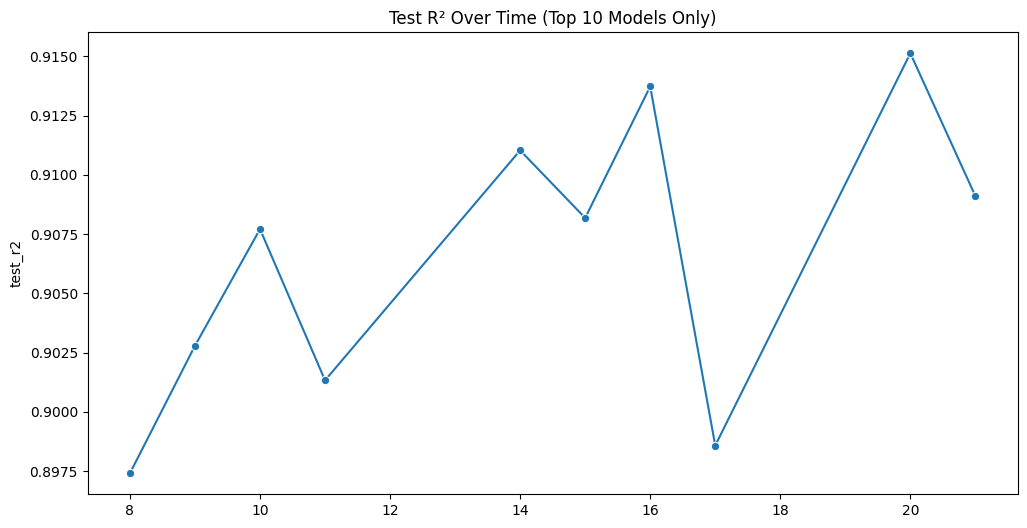

In [35]:
df = nonlinear_bucket.get_results_df()
top10 = df.sort_values("test_r2", ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.lineplot(data=top10, x=top10.index, y='test_r2', marker='o')
plt.title("Test R² Over Time (Top 10 Models Only)")
plt.show()

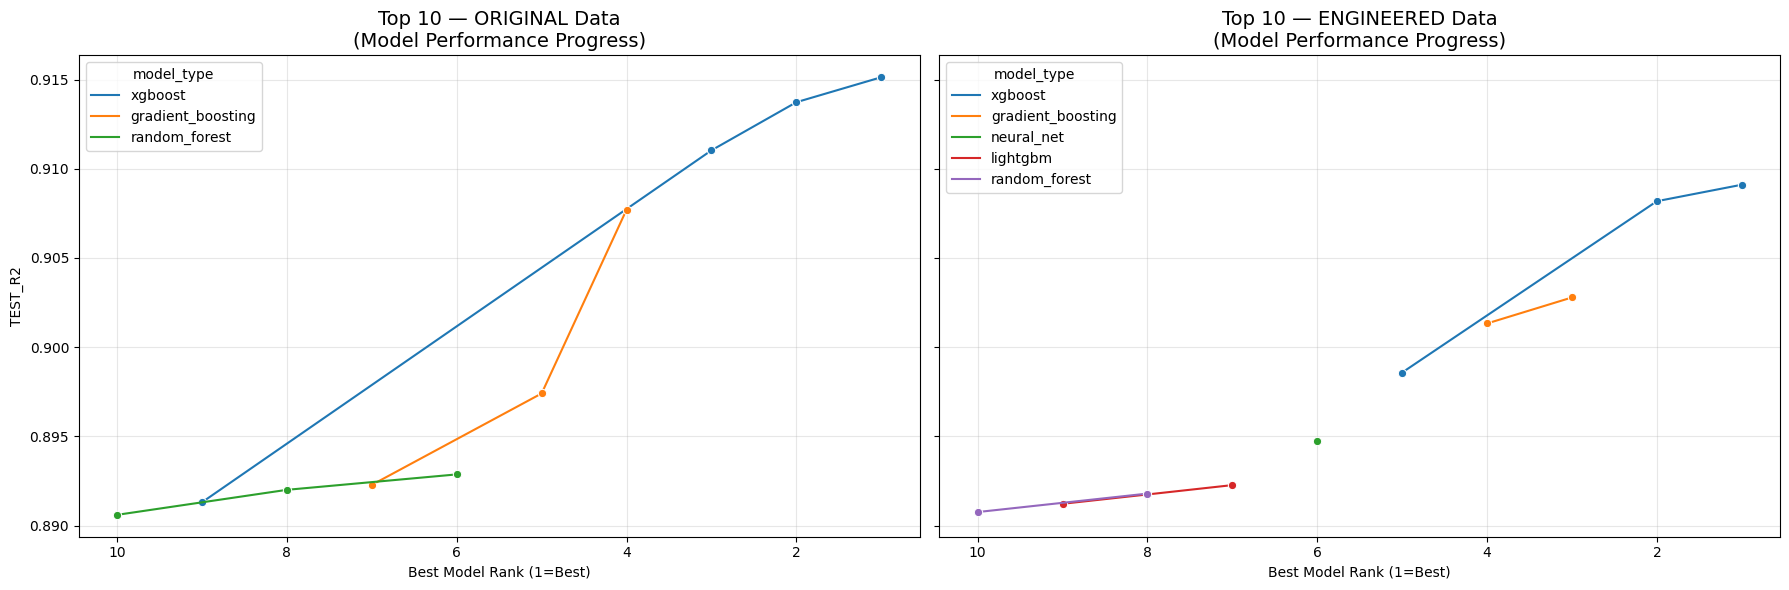

In [36]:
plot_progress_split_top10(nonlinear_bucket, metric="test_r2")

BEST MODEL PROGRESSION


,rank,model_id,model_type,data_version,params,test_r2
20,1,xgboost_original_colsample_bytree0.8_devicecud...,xgboost,original,"{'n_estimators': 500, 'learning_rate': 0.01, '...",0.915130
16,2,xgboost_original_devicecuda_learning_rate0.05_...,xgboost,original,"{'n_estimators': 200, 'learning_rate': 0.05, '...",0.913729
14,3,xgboost_original_devicecuda_learning_rate0.1_m...,xgboost,original,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",0.911033
21,4,xgboost_engineered_colsample_bytree0.8_devicec...,xgboost,engineered,"{'n_estimators': 500, 'learning_rate': 0.01, '...",0.909105
15,5,xgboost_engineered_devicecuda_learning_rate0.1...,xgboost,engineered,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",0.908182
10,6,gradient_boosting_original_learning_rate0.05_m...,gradient_boosting,original,"{'n_estimators': 200, 'learning_rate': 0.05, '...",0.907711
9,7,gradient_boosting_engineered_learning_rate0.1_...,gradient_boosting,engineered,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",0.902788
11,8,gradient_boosting_engineered_learning_rate0.05...,gradient_boosting,engineered,"{'n_estimators': 200, 'learning_rate': 0.05, '...",0.901330
17,9,xgboost_engineered_devicecuda_learning_rate0.0...,xgboost,engineered,"{'n_estimators': 200, 'learning_rate': 0.05, '...",0.898580
8,10,gradient_boosting_original_learning_rate0.1_ma...,gradient_boosting,original,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",0.897409


/tmp/ipykernel_47/2096146876.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


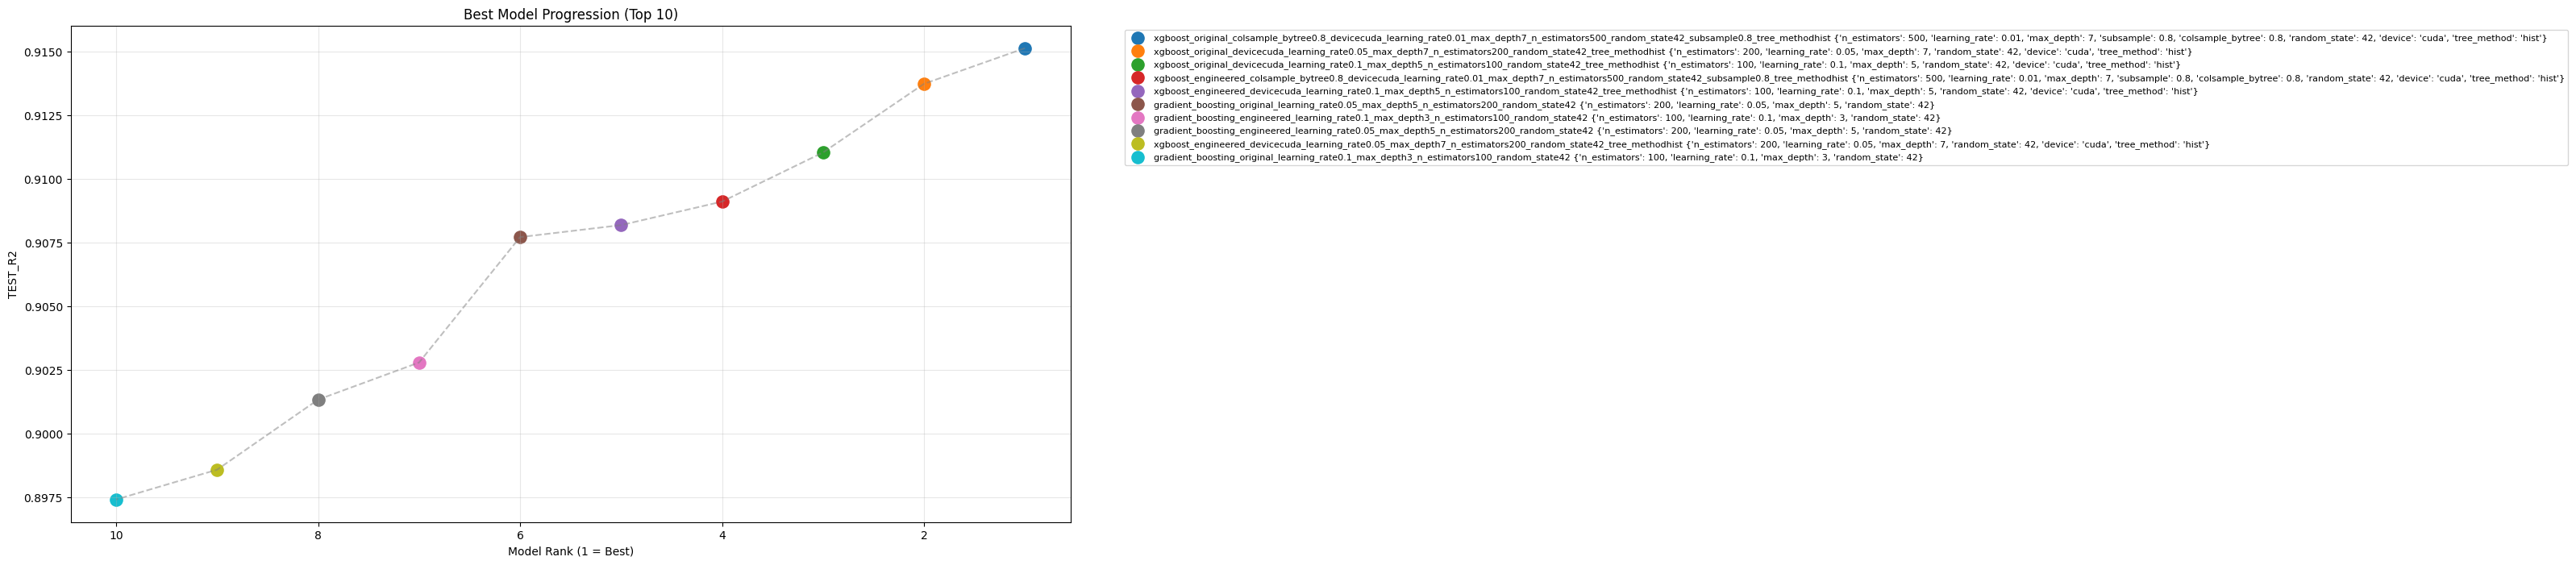

In [37]:
top_models = plot_best_model_progression(nonlinear_bucket, metric="test_r2", top_n=10)

# Submission

In [45]:
test =  pd.read_csv(path)
test_ids = test['Id']

In [46]:
X_test = test_orig.drop(columns=['SalePrice'], errors='ignore')
preds = nonlinear_bucket.predict(best_id, X_test)

In [49]:
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': preds 
})

# 7. Save to CSV
submission.to_csv('submission.csv', index=False)